# Sponsorship models

Consider senate number 115, this notebook aims to predict votes profile for a bill using the sponsors' votes information.

Any other information on each senator can be encoded on a similarity graph.

In [1]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import ast
from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline 
%load_ext autoreload
%autoreload

from lib import models_alt, graph, coarsening, utils

In [2]:
VOTES_115 = '../data/all-votes/votes_115.csv'
BILLS_115 = '../data/bills_115.csv'
ADJACENCY = '../data/adjacency.csv'

In [3]:
all_bills = pd.read_csv(BILLS_115)
votes_115 = pd.read_csv(VOTES_115)
bills_sen = all_bills[all_bills.sponsor_title=='Sen.'] # bills sponsored by senators
N_BILLS_SEN = bills_sen.shape[0]

In [4]:
members_aux = pd.DataFrame(list(votes_115['member_id'].unique())).rename(columns={0: 'member_id'})
members = members_aux.merge(votes_115.drop_duplicates(subset = 'member_id')[['member_id', 'party']], how='left').sort_values(['party', 'member_id'])
N_SENATORS = len(members)

In [5]:
def numeric_votes(x):
    if x == 'Yes':
        return 1
    elif x == 'Not Voting' or pd.isnull(x):
        return 0 # we can put np.nan and then fill with the median or mean, whatever for now
    else:
        return -1

In [6]:
votes_matrix=np.zeros((len(votes_115.vote_uri.unique()), N_SENATORS))

for i, l in enumerate(list(votes_115.vote_uri.unique())):
    votes = (members.merge(votes_115[votes_115.vote_uri == l], how='left'))
    feature = votes.vote_position.apply(numeric_votes).values
    votes_matrix[i] = feature

In [7]:
votes_matrix.shape

(599, 105)

In [8]:
for i,j in enumerate(bills_sen.cosponsors_sen):
    bills_sen.cosponsors_sen.iloc[i] = ast.literal_eval(j)

In [9]:
bills_sen.head()

,Unnamed: 0,bill_api_uri,date,democrats_no,democrats_yes,independent_no,independent_yes,month,republican_no,republican_yes,...,sponsor_id,sponsor_party,sponsor_title,result_ok,nb_cosponsors_R,nb_cosponsors_D,nb_cosponsors_I,cosponsors_sen,cosponsors_rep,cosponsors_del
1,1,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,16,30,1,1,1,0,50,...,M000303,R,Sen.,passed,0,0,0,[],[],[]
2,3,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,0,45,0,2,1,49,2,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]
3,4,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,45,0,2,0,1,0,51,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]
4,5,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,0,45,0,2,1,49,2,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]
5,6,https://api.propublica.org/congress/v1/115/bil...,2017-01-11,44,1,2,0,1,0,51,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]


Create binary matrices indicating sponsorship (and cosponsorship):

In [10]:
S = np.zeros((N_BILLS_SEN, N_SENATORS))
for i, j in enumerate(bills_sen.cosponsors_sen):
    S[i, list(members['member_id']).index(bills_sen.sponsor_id.iloc[i])] = 1

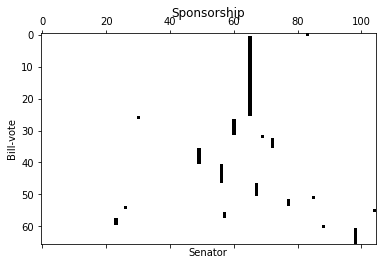

In [11]:
plt.spy(S)
plt.title('Sponsorship')
plt.xlabel('Senator')
plt.ylabel('Bill-vote');

In [12]:
CS = np.zeros((N_BILLS_SEN, N_SENATORS))
for i, j in enumerate(bills_sen.cosponsors_sen):
    for k, l in enumerate(bills_sen.cosponsors_sen.iloc[i]):
        CS[i, list(members['member_id']).index(bills_sen.cosponsors_sen.iloc[i][k])] = 1

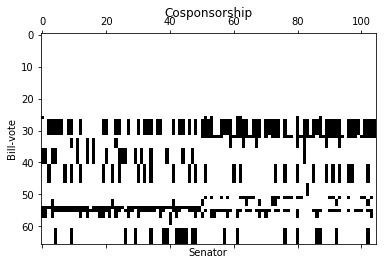

In [13]:
plt.spy(CS)
plt.title('Cosponsorship')
plt.xlabel('Senator')
plt.ylabel('Bill-vote');

In [14]:
Z = S + CS # sponsorship mask

Get all votes for each bill-vote:

In [15]:
Y=np.zeros((N_BILLS_SEN, N_SENATORS))

for i, l in enumerate(list(bills_sen.vote_uri)):
    votes = (members.merge(votes_115[votes_115.vote_uri == l], how='left'))
    feature = votes.vote_position.apply(numeric_votes).values
    Y[i] = feature

In [16]:
Y.shape

(66, 105)

Use as feature vector the voting profile for each senator:

In [17]:
X = np.zeros((N_BILLS_SEN, N_SENATORS))
X[Z==1]=Y[Z==1]

In [18]:
X.shape

(66, 105)

In [19]:
n = X.shape[0]
d = X.shape[1]

print('n = {}\nd = {}'.format(n, d))

n = 66
d = 105


In [74]:
n_train = n//2
n_val = n//10

perm_idx = np.random.permutation(n)
X_train = X[perm_idx[:n_train]]
X_val = X[perm_idx[n_train:n_train+n_val]]
X_test = X[perm_idx[n_train+n_val:]]

y_train = Y[perm_idx[:n_train]]
y_val = Y[perm_idx[n_train:n_train+n_val]]
y_test = Y[perm_idx[n_train+n_val:]]


In [75]:
# adj = sparse.csr_matrix(np.genfromtxt(ADJACENCY, delimiter = ','), dtype = np.float32)

In [76]:
dist, idx = graph.distance_scipy_spatial(votes_matrix.T, k=40, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)

d = |V| = 105, k|V| < |E| = 5012


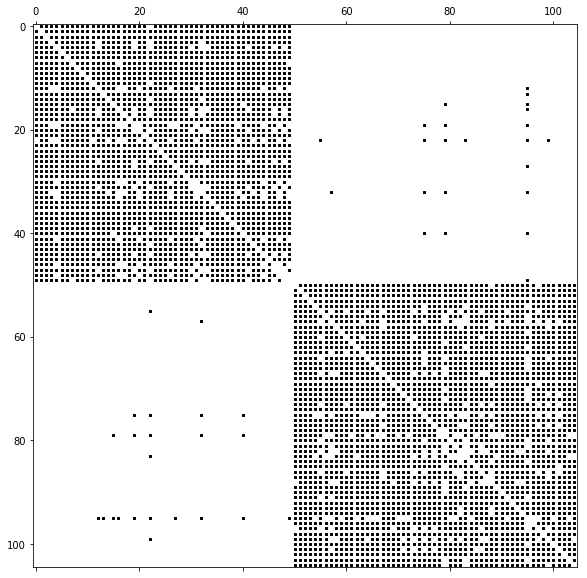

In [77]:
print('d = |V| = {}, k|V| < |E| = {}'.format(d, A.nnz))
plt.figure(figsize=(10,10))
plt.spy(A, markersize=2, color='black');

In [78]:
L = [graph.laplacian(A, normalized=True) for z in range(2)]

/Users/virginiabordignon/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


(0, 1.1607812411832616)

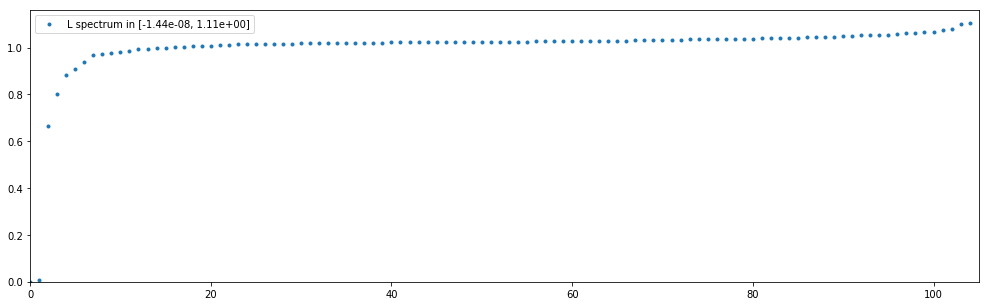

In [79]:
plt.figure(figsize=(17, 5))
lamb, U = np.linalg.eigh(L[0].toarray())
x = range(0, L[0].shape[0])
lb = 'L spectrum in [{:1.2e}, {:1.2e}]'.format(lamb[0], lamb[-1])
plt.plot(x, lamb, '.', label=lb)
plt.legend(loc='best')
plt.xlim(0, L[0].shape[0])
plt.ylim(ymin=0)

## CNN

CNN model was adapted for performing regression instead of classification (see file model_alt.py).

In [80]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 50
params['batch_size']     = 10 # changed
params['eval_frequency'] = 20 # changed

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = A.shape[0]

# Architecture.
params['F']              = [32, 64]  # Number of graph convolutional filters.
params['K']              = [2, 2]  # Polynomial orders.
params['p']              = [1, 1]    # Pooling sizes.
params['M']              = [C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = .7 # changed
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

In [81]:
model = models_alt.cgcnn(L, **params)
loss_train, loss_val, t_step = model.fit(X_train, y_train, X_val, y_val)

NN architecture
  input: M_0 = 105
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 105 * 32 / 1 = 3360
    weights: F_0 * F_1 * K_1 = 1 * 32 * 2 = 64
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 105 * 64 / 1 = 6720
    weights: F_1 * F_2 * K_2 = 32 * 64 * 2 = 4096
    biases: F_2 = 64
  layer 3: logits (softmax)
    representation: M_3 = 105
    weights: M_2 * M_3 = 6720 * 105 = 705600
    biases: M_3 = 105
step 20 / 165 (epoch 6.06 / 50):
  learning_rate = 7.74e-04, loss_average = 2.40e+00
  validation loss: 3.49e+00
  time: 1s (wall 0s)
step 40 / 165 (epoch 12.12 / 50):
  learning_rate = 5.69e-04, loss_average = 2.38e+00
  validation loss: 3.27e+00
  time: 1s (wall 1s)
step 60 / 165 (epoch 18.18 / 50):
  learning_rate = 4.18e-04, loss_average = 2.33e+00
  validation loss: 3.22e+00
  time: 2s (wall 1s)
step 80 / 165 (epoch 24.24 / 50):
  learning_rate = 3.07e-04, loss_average = 2.30e+00
  validation loss: 3.20e+00
  time: 2s (wall 1s)
step 100

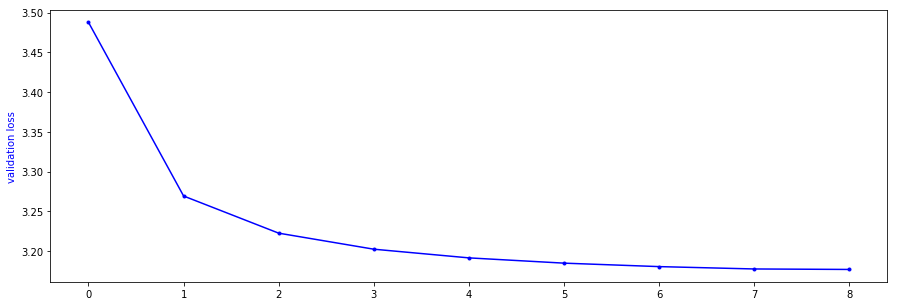

In [82]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(loss_val, 'b.-')
ax1.set_ylabel('validation loss', color='b')
# ax2 = ax1.twinx()
# ax2.plot(loss_train, 'g.-')
# ax2.set_ylabel('training loss', color='g')
plt.show()

In [83]:
res = model.evaluate(X_test, y_test)
print(res[0])

INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-165
loss: 2.41e+00
time: 0s (wall 0s)


In [84]:
def eval_prediction(Pred):
    Pred_bool = (Pred-Pred.mean(axis=1)[:,np.newaxis])>0
    Pred[Pred_bool] = 1
    Pred[~Pred_bool] = -1
    return Pred

In [85]:
Pred_train = model.predict(X_train)
Pred_test = model.predict(X_test)
Pred_train = eval_prediction(Pred_train)
Pred_test = eval_prediction(Pred_test)


INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-165
INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-165


In [86]:
from matplotlib.colors import ListedColormap
mycmap = ListedColormap(['blue','white','red'])


Votes color:
- Red: Yes
- Blue: No


Text(0.5, 1.0, 'Training truth')

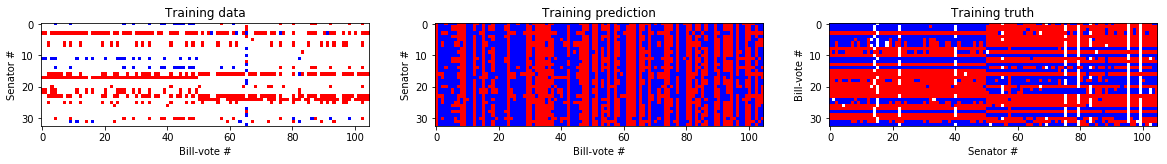

In [87]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Training data')
plt.subplot(1,3,2)
plt.imshow(Pred_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Training prediction')
plt.subplot(1,3,3)
plt.imshow(y_train, vmax = 1, vmin=-1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Training truth')

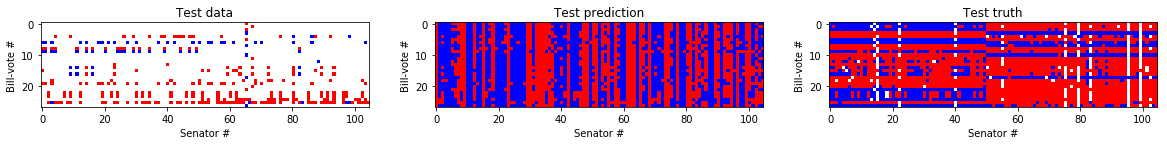

In [88]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test data')
plt.subplot(1,3,2)
plt.imshow(Pred_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test prediction')
plt.subplot(1,3,3)
plt.imshow(y_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test truth');

## Estimate graph filter - linear regression

In [89]:
from sklearn import linear_model
import scipy


def accuracy(pred, truth):
    not_vot = np.not_equal(truth, 0)
    a = np.equal(pred, truth)
    acc=np.sum(a[not_vot])/np.size(truth[not_vot])
    return acc

def build_pol_base(X, Laplacian, K):
    tX=[]
    for i in range(K):
        tX.append(np.array(X @ np.linalg.matrix_power(Laplacian, i)))
    return tX

def build_pol_base_exp(X, Laplacian, K, a):
    tX=[]
    for i in range(K):
        tX.append(np.array(X @ scipy.linalg.expm(k*a*Laplacian)))
    return tX

def get_reg_matrices(K, y, tX):
    M=np.zeros((K,K))
    Ym = np.zeros(K)
    for i in range(K):
        for j in range(K):
            M[i,j] = np.sum(tX[i] * tX[j])
        Ym[i] = np.sum(tX[i] * y)
    return M, Ym

def get_reg_matrices2(K, y, tX):
    D = y.shape[1]
    M= np.zeros((D*K, D*K))
    Ym = np.zeros(D*K)
    for i in range(K):
        for j in range(K):
            aux = np.sum(tX[i] * tX[j], axis = 0)
            np.fill_diagonal(M[D*i: D*(i+1),D*j: D*(j+1)], aux)
        Ym[D*i:D*(i+1)] = np.sum(tX[i] * y, axis = 0)
    return M, Ym

def train_ls(M, Ym):
    reg = linear_model.LinearRegression()
    reg.fit(M, Ym)
    theta = reg.coef_
    return theta

def predict(tX, theta):
    Pred = sum([theta[i]*j for i, j in enumerate(tX)])
    Pred_bool = (Pred-Pred.mean(axis=1)[:,np.newaxis])>0
    Pred[Pred_bool] = 1
    Pred[~Pred_bool] = -1
    return Pred

def predict2(tX, theta):
    Pred = sum([j@theta[i] for i, j in enumerate(tX)])
    Pred_bool = (Pred-Pred.mean(axis=1)[:,np.newaxis])>0
    Pred[Pred_bool] = 1
    Pred[~Pred_bool] = -1
    return Pred

In [90]:
Laplacian = L[0].todense()

In [91]:
Laplacian.shape

(105, 105)

In [92]:
K = 4  # Filter parameters
tX = build_pol_base(X_train, Laplacian, K)
M, Ym = get_reg_matrices(K, y_train, tX)
theta = train_ls(M, Ym)
Pred = predict(tX, theta)
accuracy(Pred, y_train)

0.8124614435533621

Text(0.5, 1.0, 'Training truth')

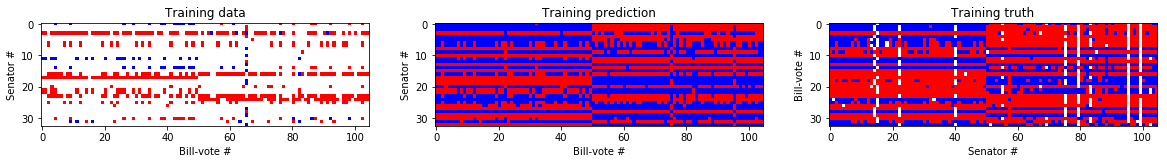

In [93]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Training data')
plt.subplot(1,3,2)
plt.imshow(Pred, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Training prediction')
plt.subplot(1,3,3)
plt.imshow(y_train, vmax = 1, vmin=-1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Training truth')


Test:

In [94]:
tX_test = build_pol_base(X_test, Laplacian, K)

Pred_test = predict(tX_test, theta)
accuracy(Pred_test, y_test)

0.7187145557655955

Text(0.5, 1.0, 'Test truth')

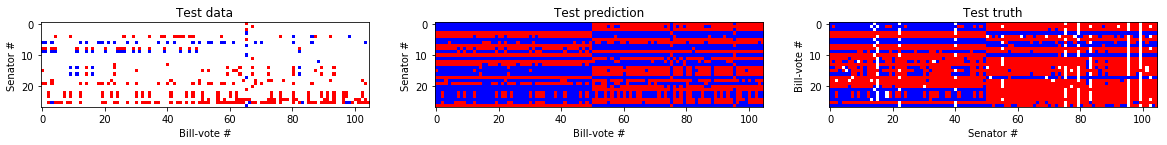

In [95]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Test data')
plt.subplot(1,3,2)
plt.imshow(Pred_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Test prediction')
plt.subplot(1,3,3)
plt.imshow(y_test, vmax = 1, vmin=-1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test truth')

### Model 1:

Estimate the polynomial graph filter $f(L) = \sum^K_k \alpha_k L^k$ using least squares:
1. Solve: 
$$\min_{\alpha}\left\Vert Y-\sum^K_{k=0} \alpha_k L^k X\right\Vert^2$$

In [96]:
acc_test = []
acc_train = []
k_vec = range(2, 200)
for k in k_vec:
    tX_train = build_pol_base(X_train, Laplacian, k)
    M, Ym = get_reg_matrices(k, y_train, tX_train)
    theta = train_ls(M, Ym)
    tX_test = build_pol_base(X_test, Laplacian, k)
    Pred_test = predict(tX_test, theta)
    Pred_train = predict(tX_train, theta)
    acc_train.append(accuracy(Pred_train, y_train))
    acc_test.append(accuracy(Pred_test, y_test))

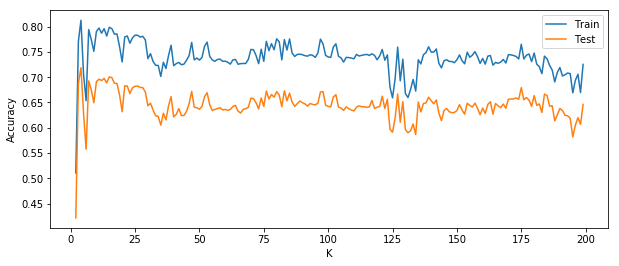

In [97]:
plt.figure(figsize=(10,4))
plt.plot(k_vec, acc_train)
plt.plot(k_vec, acc_test)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])

In [98]:
print(np.max(acc_test))
print(np.argmax(acc_test))

0.7187145557655955
2


### Model 2:

Estimate the polynomial graph filter $f(L) = \sum^K_k A_k L^k$ using least squares:
1. Solve: 
$$\min_{A}\left\Vert Y-\sum^K_{k=0} A_k L^k X\right\Vert^2$$

where $A_k = diag(\alpha_{1k},\dots, \alpha_{Dk})$.

In [99]:
def make_Theta(K, D, theta):
    Theta = []
    for i in range(K):
        Theta.append(np.diag(theta[i*D: (i+1)*D]))
    return Theta

In [100]:
acc_test = []
acc_train = []
k_vec = range(2, 50)
for k in k_vec:
    tX_train = build_pol_base(X_train, Laplacian, k)
    M, Ym = get_reg_matrices2(k, y_train, tX_train)
    theta = train_ls(M, Ym)
    Theta = make_Theta(k, y_train.shape[1], theta)
    tX_test = build_pol_base(X_test, Laplacian, k)
    Pred_test = predict2(tX_test, Theta)
    Pred_train = predict2(tX_train, Theta)
    acc_train.append(accuracy(Pred_train, y_train))
    acc_test.append(accuracy(Pred_test, y_test))

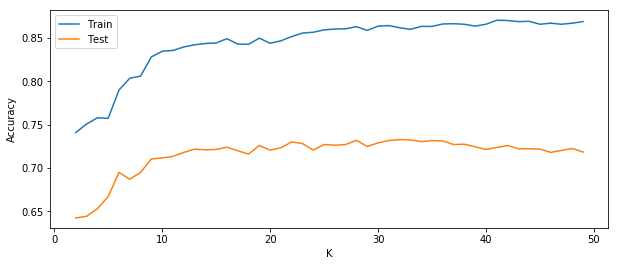

In [101]:
plt.figure(figsize=(10,4))
plt.plot(k_vec, acc_train)
plt.plot(k_vec, acc_test)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])

In [102]:
print(np.max(acc_test))
print(np.argmax(acc_test))

0.732703213610586
30


### Model 3:

Estimate the polynomial graph filter $f(L) = \sum^K_k \alpha_k e^{k\tau L}$ using least squares:
1. Solve: 
$$\min_{\alpha}\left\Vert Y-\sum^K_{k=0} \alpha_k e^{k\tau L} X\right\Vert^2$$


In [103]:
a_vec= np.logspace(-5, 0, 20)
acc_test = []
acc_train = []
k_vec = range(2, 50)
for a in a_vec:
    for k in k_vec:
        tX_train = build_pol_base_exp(X_train, Laplacian, k, a)
        M, Ym = get_reg_matrices(k, y_train, tX_train)
        theta = train_ls(M, Ym)
        tX_test = build_pol_base_exp(X_test, Laplacian, k, a)
        Pred_test = predict(tX_test, theta)
        Pred_train = predict(tX_train, theta)
        acc_train.append(accuracy(Pred_train, y_train))
        acc_test.append(accuracy(Pred_test, y_test))

In [104]:
acc_train_ = np.array(acc_train).reshape(len(a_vec),len(k_vec))
acc_test_ = np.array(acc_test).reshape(len(a_vec),len(k_vec))

Text(0.5, 1.0, 'Test accuracy')

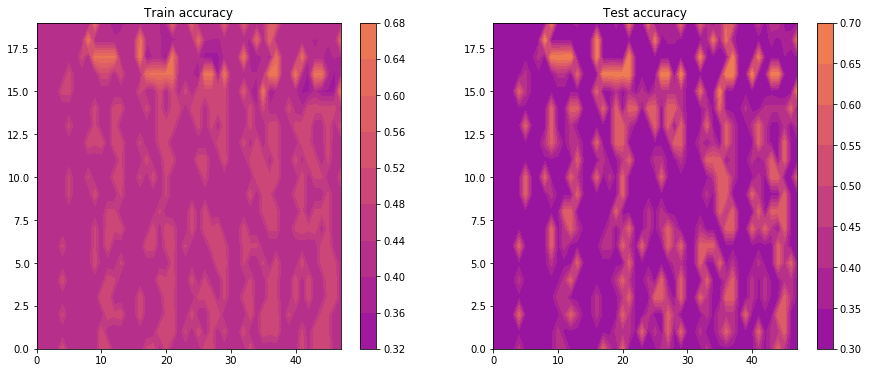

In [105]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
im1 = ax[0].contourf(acc_train_, vmin = 0, vmax = 1,cmap ='plasma')
im2 = ax[1].contourf(acc_test_, vmin = 0, vmax = 1, cmap = 'plasma')
plt.colorbar(im1, ax = ax[0])
plt.colorbar(im2, ax = ax[1])
ax[0].set_title('Train accuracy')
ax[1].set_title('Test accuracy')


In [107]:
np.max(acc_test_)

0.6956521739130435